# Machine Learning Algorithms using NumPy

Athens University of Economics and Business

Department of Computer Science

Saturday, 24 February, 2024

---

**Course**: Machine Learning (INF 3745)

**Professor**: Themos Stafylakis

---

Notebook Authors:

Alexios Mandelias (Student ID: 3190106)

Anna-Lefkothea Papavasileiou (Student ID: 6190101)

# The Task

The task we'll be tackling in this notebook involved classifying data about flowers. We have a set of $150$ observations, each with a number of features related to flower characteristics (for example, the size of their petals). The goal is to accurately classify a new flower to one of the three different species present in our dataset.

We start by importing all the necessary libraries

In [ ]:
from sklearn import datasets
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

import itertools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# The Data

We will use the well-known [Iris Flower Dataset]. For our own convenience, we will load it directly from the [`sklearn`] library.

The first two features of each observation are plotted in a scatterplot below, along with the class of each observation encoded as its color.

[Iris Flower Dataset]: https://en.wikipedia.org/wiki/Iris_flower_data_set
[`sklearn`]: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

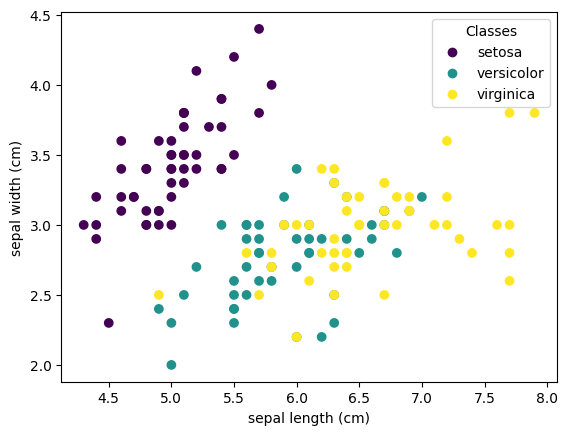

In [ ]:
def get_plot_iris():
    iris = datasets.load_iris()

    _, ax = plt.subplots()
    scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
    ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
    _ = ax.legend(
        scatter.legend_elements()[0], iris.target_names,
        loc="upper right", title="Classes"
    )

    return iris

iris_sklearn = get_plot_iris()

We extract the relevant information from the iris dataset, namely:
- `x`: the data, one row of features for each observation
- `y`: the class of each observation
- `x_labels`: the feature names
- `y_labels`: the class names

In [ ]:
x = iris_sklearn.data.astype(np.float32)
y = iris_sklearn.target
x_labels = iris_sklearn.feature_names
y_labels = iris_sklearn.target_names

print(f"{x.shape=}, {y.shape=}")
print(f"{x_labels=}")
print(f"{y_labels=}")

x.shape=(150, 4), y.shape=(150,)
x_labels=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
y_labels=array(['setosa', 'versicolor', 'virginica'], dtype='<U10')


And then perform standardization to our data. The features already have a similar scale (length measured in centimeters), however they each have a different mean and standard deviation, which worsens the performance of most algorithms.

In [ ]:
def standardize(arr):
    m = np.mean(arr)
    s = np.std(arr)
    return (arr - m) / s

x = np.apply_along_axis(standardize, axis=0, arr=x)

We define the `Dataset` class to store our data. It is responsible for splitting the data to train and test sets according to the `train_size` parameter, and also for computing other useful fields from the raw data provided to its constructor.

This class has the following public fields:
- `x`: the data, one row of features for each observation
- `y`: the class of each observation
- `x_labels`: the feature names
- `y_labels`: the class names
- `n_examples`: the number of examples
- `n_features`: the number of features
- `classes`: the unique classes of the data
- `n_classes`: the number of unique classes
- `n_train`: the number of observations to use for training
- `n_test`: the number of observations to use for testing
- `x_train`: the observations to use for training
- `y_train`: the classes of the observations used for training
- `x_test`: the observations to use for testing
- `y_test`: the classes of the observations used for testing
- `to_one_hot_index`: 'class -> one-hot index' function
- `from_one_hot_index`: 'one-hot index -> class' function
- `y_train_as_one_hot`: the classes of each train observation encoded as a one-hot vector
- `y_test_as_one_hot`: the classes of each test observation encoded as a one-hot vector

In [ ]:
class Dataset:
    def __init__(self, x, y, x_labels, y_labels, train_size, random_state=None):
        if random_state != None:
            np.random.seed(random_state)

        self.x = x
        self.y = y
        self.x_labels = x_labels
        self.y_labels = y_labels

        self.n_examples = x.shape[0]
        self.n_features = x.shape[1]
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)

        self.n_train = np.floor(train_size * self.n_examples).astype(np.int32)
        self.n_test = self.n_examples - self.n_train

        indices = np.random.permutation(np.arange(self.n_examples))
        train_indices, test_indices = np.split(indices, [self.n_train])

        self.x_train, self.y_train = x[train_indices], y[train_indices]
        self.x_test, self.y_test = x[test_indices], y[test_indices]

        _class_to_one_hot_index_dict = {
            k: index for k, index in zip(self.classes, np.arange(self.n_classes))
        }
        _one_hot_index_to_class_dict = {
            index: k for k, index in _class_to_one_hot_index_dict.items()
        }

        # convert class k to its 1-index in the one-hot encoded vector
        self.to_one_hot_index = np.vectorize(lambda yi: _class_to_one_hot_index_dict[yi])
        # convert the 1-index in the one-hot encoded vector to class k
        self.from_one_hot_index = np.vectorize(lambda ti: _one_hot_index_to_class_dict[ti])

        _y_as_one_hot = np.zeros((self.n_examples, self.n_classes))
        _y_as_one_hot[
            # rows: 0, 1, 2, ..., n_examples
            np.arange(self.n_examples),
            # columns: y to its index in the one-hot encoding scheme
            np.apply_along_axis(self.to_one_hot_index, 0, y)
        ] = 1 # set to one to form one-hot vector

        self.y_train_as_one_hot = _y_as_one_hot[train_indices]
        self.y_test_as_one_hot = _y_as_one_hot[test_indices]

    def get_train_dataloader(self, batch_size):
        dataset = _DummyDataset(self.x_train, self.y_train)
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    def get_test_dataloader(self, batch_size):
        dataset = _DummyDataset(self.x_test, self.y_test)
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

# used only in the get_xxx_dataloader() methods of Dataset
class _DummyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._size = len(self._x)

    def __len__(self):
        return self._size

    def __getitem__(self, idx):
        return (self._x[idx], self._y[idx])

We use our `Dataset` class to create the `iris_dataset` object, which will be used in every subsequent model.

We specify that $67\%$ of the observations will be used for training, and that the random shuffling thereof will be performed given a fixed random state, for reproducibility purposes.

In [ ]:
iris_dataset = Dataset(x, y, x_labels, y_labels, 0.67, random_state=42)

# The Machine Learning

To tackle the problem of classifying some new observation $\mathbf{x}$, we will implement $5$ classification algorithms from scratch using the `numpy` library. In addition, we will implement an algorithm for dimensionality reduction and one for clustering, as if our data was not already labeled.

The five classification algorithms are:
- [`Least Squares`](https://en.wikipedia.org/wiki/Least_squares)
- [`Logistic Regression`](https://en.wikipedia.org/wiki/Logistic_regression)
- [`K Nearest Neighbors`](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
- [`Naive Bayes`](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [`Multilayer Perceptron`](https://en.wikipedia.org/wiki/Multilayer_perceptron)

For dimensionality reduction we will use [`Principal Component Analysis`](https://en.wikipedia.org/wiki/Principal_component_analysis).

We will perform clustering using the [`K Means`](https://en.wikipedia.org/wiki/K-means_clustering) algorithm.

The clustering algorithms will be adapted, where necessary, to work for our multi-class classification problem.

To aid the presentation, $\LaTeX$ will be used throughout this notebook to showcase the relevant mathematical background behind each algorithm.
$\newcommand{\T}{\text{T}}$
$\newcommand{\b}[1]{\mathbf{#1}}$
$\newcommand{\bt}[1]{\widetilde{\b{#1}}}$
$\newcommand{\bT}[1]{\b{#1}^{\T}}$
$\newcommand{\btT}[1]{\bt{#1}^{\T}}$

## Utility Classes and Functions

### Models

We define a `BaseModel` with the common functionality between the models we'll be making. Each model which derives from it will need to override three methods:
- `setup()` (optional): configures the model according to some training hyperparameters passed as `**kwargs`.
- `fit_impl()`: fits the model to `self.dataset`.
- `predict_one()`: predicts (classifies) one new observation according to the model's parameters after fitting, and returns the class of the new observation.

The `fit()` method should not be overriden as it is responsible for setting `self.dataset` and calling the abstract `fit_impl()` method.

The `predict()` method takes a matrix of observations as its input and by default calls `predict_one()` for each observation. However, it can be overridden if classifying a matrix of observations is more convenient than classifying one observation (as in the case in linear regression, where for a matrix of observations $\b{X}$ the classification $\b{Y(X)}$ is as follows: $\b{Y}(\b{X}) = \left(\bT{W}\bT{X}\right)^\text{T}$).

Each derived model should define its parameters in its `__init__()` method, set these parameters in its `setup()` method and then use them to predict the class of a new observation in its `predict_one()` (or `predict()`) method.

In [ ]:
class BaseModel:
    def __init__(self, name):
        self.name = name
        self.dataset = None

    def setup(self, **kwargs):
        pass

    def fit(self, dataset):
        self.dataset = dataset
        self.fit_impl()

    def fit_impl(self):
        raise NotImplementedError()

    def predict_one(self, x):
        raise NotImplementedError()

    def predict(self, x):
        return np.apply_along_axis(
            self.predict_one, axis=1, arr=x
        )

    def __str__(self):
        return f"Model: {self.name}"

To facilitate comparing our models with the ones provided in the sklearn library, we define the `SklearnModelAdapter` class, which wraps an sklearn model with our `BaseModel`, so that it can be used in the `show_report()` function below without any further changes.

In [ ]:
class SklearnModelAdapter(BaseModel):
    def __init__(self, sklearn_model_class):
        super().__init__(sklearn_model_class.__name__)
        self.model_class = sklearn_model_class
        self.model = None # to be instantiated in `setup`

    def setup(self, **kwargs):
        self.model = self.model_class(**kwargs)

    def fit_impl(self):
        self.model.fit(self.dataset.x_train, self.dataset.y_train)

    def predict(self, x):
        return self.model.predict(x)

### Reporting

We define the `show_report()` function which produces statistics for a given model and dataset. The model is fitted to the dataset and it then transforms some data to produce statistics. The function takes 7 parameters:
- `model`: an instance of `BaseModel`, the model to use
- `dataset`: an instance of `Dataset`, the dataset to use
- `hyperparameters` (default=`{}`): a dictionary with the different hyperparameters to use to train the model. The cartesian product of the hyperparameters is calculated, and the model is trained once for every resulting tuple of hyperparameter values, which as passed as `kwargs` to the model's `fit` function. Example: `h = { 'K': range(1, 6), 'loss': ["cross-entropy", "least-squares"], 'epochs': [10] }`
- `show_train` (default=`True`): whether to show statistics for the train data
- `show_test` (default=`True`): whether to show statistics for the test data
- `show_total` (default=`True`): whether to show the statistics aggregated for all classes
- `classes_to_show` (default=`[]`): for which classes to show individual statistics.

In [ ]:
def _accuracy(y, y_hat, class_=None):
    if (class_ != None) and (class_ in y):
        idx = np.where(y == class_)
    else:
        idx = np.arange(y.shape[0])
    return np.sum(y[idx] == y_hat[idx]) / y[idx].shape[0]

def _classification_report_for_class(y, y_hat, class_=None):
    if (class_ != None) and (class_ in y):
        idx = np.where(y == class_)
    else:
        idx = np.arange(y.shape[0])
    return classification_report(y[idx], y_hat[idx])

def show_report(model: BaseModel, dataset, hyperparameters={}, simple=True,
                show_train=True, show_test=True, show_total=True,
                classes_to_show=[]):

    # print model information
    print(model)

    # take cartesian product of all the hyperparameters
    h_names = sorted(hyperparameters.keys())
    h_values = map(hyperparameters.get, h_names)
    for prod in itertools.product(*h_values):
        params = dict(zip(h_names, prod))

        indentation = ""
        if len(params) > 0:
            indentation = "\t"
            format = "%s = %s"
            params_str = ', '.join(format % (k, v) for k, v in params.items())
            print(f"Fitting with hyperparameters: {params_str}")

        # setup the model with the hyperparameters
        model.setup(**params)

        # fit the model to the train data
        model.fit(dataset)

        # don't mutate the default parameter `classes_to_show`
        classes_to_print = list(classes_to_show)
        if show_total:
            classes_to_print = [None] + classes_to_print

        if show_train:
            y_hat_train = model.predict(dataset.x_train)
            for k in classes_to_print:
                class_str = f' for class {k}' if k != None else ''
                if simple:
                    acc_train = _accuracy(dataset.y_train, y_hat_train, k)
                    print(f"{indentation}Train accuracy{class_str}: {acc_train:.4f}")
                else:
                    print(f"{indentation}Train results{class_str}:")
                    print(_classification_report_for_class(
                        dataset.y_train, y_hat_train, k
                    ))

        if show_test:
            y_hat_test = model.predict(dataset.x_test)
            for k in classes_to_print:
                class_str = f' for class {k}' if k != None else ''
                if simple:
                    acc_test = _accuracy(dataset.y_test, y_hat_test, k)
                    print(f"{indentation}Test accuracy{class_str}: {acc_test:.4f}")
                else:
                    print(f"{indentation}Test results{class_str}:")
                    print(_classification_report_for_class(
                        dataset.y_test, y_hat_test, k
                    ))

### Plotting

We define the `plot_pca()` function which plots the first two principal components of the Principal Component Analysis. It takes two parameters:
- `z`: the transformed data to plot (only the first two features are used)
- `eigvals`: the eigenvalues of the matrix used to transform the data

In [ ]:
def plot_pca(z, eigvals):
    percentage_var_explained = (eigvals / np.sum(eigvals)) * 100
    message = "Percentage of variance explained by each principal component"
    percentages = ['%.1f%%' % p for p in percentage_var_explained]
    print(f"{message}: {', '.join(percentages)}")

    scatter = plt.scatter(z[:, 0], z[:, 1], c=iris_dataset.y)
    plt.title("Principal Component Analysis")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(
        scatter.legend_elements()[0], iris_dataset.y_labels,
        loc="upper right", title="Classes"
    )
    plt.show()

Finally, we define the `plot_loss()` function, which can be used to plot the loss of a model across a number of epochs. This function provides customization options for the horizontal ticks of the plot. It takes the following parameters:
- `train_loss`: list of numbers, each corresponding to the loss of a model for an epoch, for the training data.
- `test_loss`: list of numbers, each corresponding to the loss of a model for an epoch, for the test data.
- `first_tick`: the position of the first tick. Used in cases where the loss at epoch $0$ is too big, messing up the scale of the y axis.
- `n_ticks`: the number of ticks on the x axis, including the first tick.
- `delta_epoch`: every how many epochs to put a tick.

Note: at least one of `n_ticks` and `delta_epoch` must be defined. If both are defined, `n_ticks` takes priority.

In [ ]:
def plot_loss(train_loss, test_loss, *, first_tick, n_ticks=None, delta_epoch=None):
    # if both not None, n_ticks takes precedence
    if (n_ticks is None) and (delta_epoch is None):
        print("Either of `n_ticks` or `delta_epoch` must be non-None")
        return

    num_epochs = len(train_loss)
    # epoch_ticks include end (index out of range) in both cases
    if n_ticks != None:
        epoch_ticks = np.linspace(0, num_epochs, num=n_ticks,
                                endpoint=True, dtype=np.int32)
    else:
        epoch_ticks = np.arange(0, num_epochs + 1, step=delta_epoch,
                                dtype=np.int32)

    # first tick has waaay too big loss (no training yet), last tick is out of range
    # exclude first tick, instead add `first_tick` (random small epoch)
    # exclude last tick, instead add last epoch
    epoch_ticks = np.concatenate(([first_tick], epoch_ticks[1:-1], [num_epochs-1]))

    plot_x = epoch_ticks
    plot_y_train = train_loss[plot_x]
    plot_y_test = test_loss[plot_x]

    plt.plot(plot_x, plot_y_train, "x--m", label="train loss")
    plt.plot(plot_x, plot_y_test, "x--c", label="test loss")
    # increment last epoch tick to account for epoch being 0-based (better printing)
    plt.xticks(np.concatenate((plot_x[:-1], [plot_x[-1] + 1])), rotation=90)
    plt.legend()
    plt.show()

In [ ]:
def plot_kmeans_clusters(pca_model, dataset, clusters, centroids):
    # reduce dimensionality of data (and centroids)
    # to 2, to aid the visualization
    pca_model.setup(n_components=2)
    pca_model.fit(dataset)

    data_z = pca_model.predict(dataset.x)
    centroids_z = pca_model.predict(centroids)

    # Visualize the results
    colors = ['red', 'green', 'blue']
    plt.scatter(data_z[:, 0], data_z[:, 1], c=clusters)
    plt.scatter(centroids_z[:, 0], centroids_z[:, 1], c='red',
                marker='X', s=150, label='Centroids')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title('K-means Clustering on Iris Dataset')
    plt.legend()
    plt.show()

In [ ]:
def plot_kmeans_confusion_matrix(y, y_hat, y_labels):
    cm = confusion_matrix(y, y_hat)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_labels)
    cmd.plot()

## 1. Principal Component Analysis

Source: https://en.wikipedia.org/wiki/Principal_component_analysis

### General Idea

We assume that our data (observations in the $\mathbb{R}^d$ space, where $d$ is the number of features), can be transformed to a space of less dimensionality, without significant loss of information. We fit the model to our data and linearly transform to a new coordinate system in the $\mathbb{R}^m$ space ($m < d$), such that the directions (the principal components) which capture the largest variation in the data can be easily identified.

### Math and Implementation

This transformation is defined by a set of size $l$ of $p$-dimensional vectors of weights $\b{w}_{(k)} = (w_1, \ldots, w_p)_{(k)}$, that map each row vector $\b{x}_{(i)}$ of our data matrix $\b{X}$ to a new vector of principal component scores $\b{t}_{(i)} = (t_1, \ldots, t_l)_{(i)}$, given by

$$ t_{k (i)} = \b{x}_{(i)} \cdot \b{w}_{(k)}, \hspace{0.2in} i=1, \ldots, n \hspace{0.2in} k=1, \ldots, l$$

in such a way that the individual variables $t_1, \ldots, t_l$ of $\b{t}$ considered over the data set $\b{X}$ successively inherit the maximum possible variance from it, with each coefficient vector $\b{w}$ constrained to be a unit vector.

To maximize variance, the first weiht vector $\b{w}_{(1)}$ has to satisfy:

$$ \b{w}_{(1)} = \text{argmax}_{\|w\|=1}\left\{\sum_i (t_1)^2_{(i)}\right\}  = \text{argmax}_{\|w\|=1}\left\{\sum_i (\b{x}_{(i)} \cdot \b{w})^2\right\} $$

Equivalently, writing this in matrix form gives:

$$ \b{w}_{(1)} = \text{argmax}_{\|w\|=1}\left\{{\|\b{X} \cdot \b{w}\|}^2\right\} = \text{argmax}_{\|w\|=1}\left\{\bT{w}\bT{X}\b{X}\b{w}\right\} $$

Since $\b{w}_{(1)}$ is defined to be a unit vecor, this equivalently also satisfies:

$$ \b{w}_{(1)} = \text{argmax}\left\{\frac{\bT{w}\bT{X}\b{X}\b{w}}{\bT{w}\b{w}}\right\} $$

The quantity to be maximised can be recognised as a Rayleigh quotient. A standard result for a positive semidefinite matrix such as $\bT{X}\b{X}$ is that the quotient's maximum possible value is the largest eigenvalue of the matrix, which occurs when $\b{w}$ is the corresponding eigenvector.

With $\b{w}_{(1)}$ found, the first principal component of a data vector $\b{x}_{(i)}$ can then be given as a score $t_{1(i)} = \b{x}_{(i)} \cdot \b{w}_{(1)}$ in the transformed coordinates.

The $k$-th component can be found by subtracting the first $k-1$ principal components from $\b{X}$:

$$ \hat{\b{X}}_k = \b{X} - \sum_{s=1}^{k-1} \b{X} \cdot \b{w}_{(s)} \cdot \bT{w}_{(s)} $$

and then finding the weight vector which extracts the maximum variance from this new data matrix:


$$ \b{w}_{(k)} = \text{argmax}_{\|w\|=1}\left\{{\|\hat{\b{X}}_k \cdot \b{w}\|}^2\right\} = \text{argmax}\left\{\frac{\bT{w}\hat{\b{X}}^\text{T}_k\hat{\b{X}}_k\b{w}}{\bT{w}\b{w}}\right\} $$

It turns out that this gives the remaining eigenvectors of $\bT{X}\b{X}$, with the maximum values for the quantity in brackets given by their corresponding eigenvalues. Thus the weight vectors are eigenvectors of $\bT{X}\b{X}$.

The k-th principal component of a data vector $\b{x}_{(i)}$ can therefore be given as a score $t_{k(i)} = \b{x}_{(i)} \cdot \b{w}_{(k)}$ in the transformed coordinates, where $\b{w}_{(k)}$ is the kth eigenvector of $\bT{X}\b{X}$.

The full principal components decomposition of $\b{X}$ can therefore be given as:

$$ \b{T} = \b{X}\b{W} $$

where $\b{W}$ is a $p \times p$ matrix of weights whose columns are the eigenvectors of $\bT{X}\b{X}$.

Therefore, our model has two parameters:
- `eigvals`: the resulting eigenvalues in descending order
- `eigvecs`: the resulting eigenvectors, in descending eigenvalue order

and one hyperparameter:
- `n_components`: the number of principal components

In [ ]:
class PCA(BaseModel):
    def __init__(self):
        self.n_components = None
        self._x_mean = None
        self.eigvals = None
        self.eigvecs = None

    def setup(self, n_components):
        self.n_components = n_components

To fit the PCA model we need to perform eigen-decomposition to the covariance matrix of our data, sort the resulting eigen-vectors and -values by descending eigenvalue order and keep the `n_component`-largest of them.

In [ ]:
def PCA_fit_impl(self):
    # don't mutate original x
    x = np.copy(self.dataset.x)

    # normalize x to have 0 mean
    self._x_mean = np.mean(x, axis=0)
    x_norm = x - self._x_mean

    # create covariance matrix from which to compute eigenvalues and eigenvectors
    cov = (1 / self.dataset.n_examples) * (x_norm.T @ x_norm)
    eigvals, eigvecs = np.linalg.eig(cov)

    # get m largest eigenvalues, where m the number of components
    indices_of_m_largest_eigenvalues = (
        np.argsort(eigvals) # get indices of sorted eigenvalues
            [::-1] # ... from largest to smallest
            [:self.n_components] # ... and keep first m
    )

    # keep the necessary eigenvalues and eigenvectors (first m columns)
    # according to the indices above
    self.eigvals = eigvals[indices_of_m_largest_eigenvalues]
    self.eigvecs = eigvecs[:, indices_of_m_largest_eigenvalues]

PCA.fit_impl = PCA_fit_impl

To transform some input data $\b{x}$, we first normalize it according to our train data, and then simply calculate the following transformation:

$$ \b{T} = \b{X}\b{W} $$

In [ ]:
def PCA_predict_one(self, x):
    # normalize new x to have 0 mean according to the train data
    x_norm = x - self._x_mean

    # transform the normalized data to the reduced its dimensionality
    return (self.eigvecs.T @ x_norm.T).T

PCA.predict_one = PCA_predict_one

### Results and Comparison to sklearn

Specify a value for the hyperparameter $\text{m}$ (the number of components), in this case $\text{m} = 2$.

In [ ]:
pca_hyperparameters = {
    "n_components": 2
}

Create a `PCA` model, specifying the number of comopnents, fit it to the `iris_dataset`, use it to transform the $\b{x}$ data, and plot the resulting transformed $\b{z}$ data using `plot_pca()`.


Percentage of variance explained by each principal component: 76.2%, 23.8%


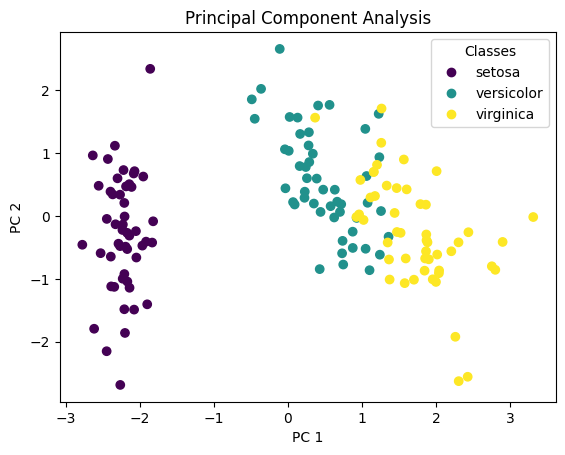

In [ ]:
pca = PCA()
pca.setup(**pca_hyperparameters)
pca.fit(iris_dataset)

z = pca.predict(iris_dataset.x)
eigvals = pca.eigvals

plot_pca(z, eigvals)

We import the [`PCA`] model from sklearn and perform the same steps as above to plot the results.

[`PCA`]: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Percentage of variance explained by each principal component: 76.2%, 23.8%


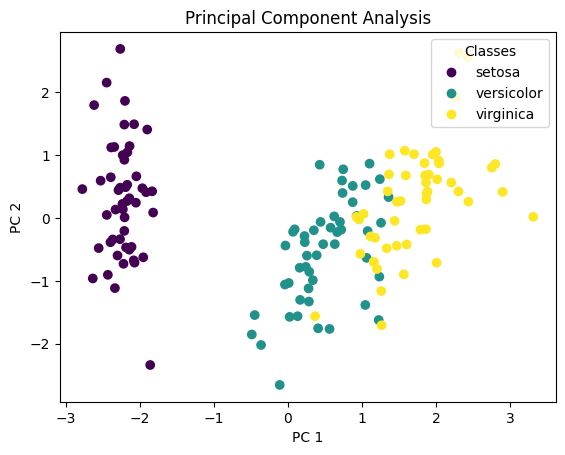

In [ ]:
from sklearn.decomposition import PCA as SklearnPCA

sklearn_pca = SklearnPCA(**pca_hyperparameters)
sklearn_pca.fit(iris_dataset.x)

sklearn_z = sklearn_pca.transform(iris_dataset.x)
sklearn_eigvals = sklearn_pca.explained_variance_ratio_

plot_pca(sklearn_z, sklearn_eigvals)

Note that the results are the same, however the `PC 2` axis is mirrored around $0$. This does not change the direction or magnitude of the principal component, only its sign. The method is still correct since that principal component still lies along the line of maximum variance.

One of the many sources supporting the (rather obvious) claim that flipping the sign of a principal component doesn't have an effect on the correctness of the method can be found [here](https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers).

## 2. Least Squares

Source: https://notesonai.com/Least+squares+for+classification.


### General Idea

We assume that for each class corresponds one linear regression line. We fit the data of each class to find the linear regression lines, and then take the argmax of the probabilities of each new observation belonging in each regression line.

### Math and Implementation

Each class $C_k$ is described by the following model:

$$y_k(\b{x}) = \bT{w}_k\b{x} + w_{k0}$$

or, equivalently,

$$\b{y}(\b{x}) = \btT{W}\bt{x}$$

where:
- $\bt{W}$ is a matrix whose $k^{th}$ column comprises the $D+1$ -dimensional vector $\bt{w}_k = (w_{k0}, \bT{w}_k)^\T$ and
- $\bt{x}$ is the corresponding augmented input vector $(1, \bT{x})^\T$ with a dummy input $x_0 = 1$.

Therefore our model has just one parameter:
- `w`: a matrix with shape (`n_features + 1`, `n_classes`), which transforms our data from feature (+ bias) space, to class space.

In [ ]:
class LinearRegression(BaseModel):
    def __init__(self):
        super().__init__("Least Squares")
        self.w = None

Assuming our training data set $\{\b{x}_n, y_n\}$, where $n = 1, ..., N$, define $\b{T}$ as a matrix whose $n^{th}$ row is the vector $\bT{t}_n$, the one-hot-encoded vector of $y_n$.

The error function can thus be written as:

$$E(\bt{W}) = \frac{1}{2}\text{Tr}\left\{(\bt{X}\bt{W}-\b{T})^\T(\bt{X}\bt{W}-\b{T})\right\}$$

We set the derivative of the error function with respect to $\bt{W}$ equal to zero, and we finally obtain the solution:

$$\bt{W} = (\btT{X}\bt{X})^{-1}\btT{X}\b{T}$$

or equivalently:

$$\bt{W}=\bt{X}^{\dagger}\b{T} $$

Therefore, to fit the model to some data we just need to solve the above equation.

In [ ]:
def LinearRegression_fit_impl(self):
    d = self.dataset
    # augment with a '1' column for the bias term
    x_train_aug = np.hstack((np.ones((d.n_train, 1)), d.x_train))

    # calculate the w matrix by setting the derivative of the
    # sum-of-squares error function equal to 0 with respect to w
    # self.w = np.linalg.inv(x_train_aug.T @ x_train_aug) @ x_train_aug.T @ y_as_one_hot
    self.w = np.linalg.pinv(x_train_aug) @ d.y_train_as_one_hot

LinearRegression.fit_impl = LinearRegression_fit_impl

We assign a new observation $\b{x}$ to the class $C_k$ if

$$k = {argmax}_j(y_j(\b{x}))$$

where

$$\b{y}(\b{x}) = \btT{W}\bt{x}$$

In [ ]:
def LinearRegression_predict(self, x):
    # augment with a '1' column for the bias term
    x_aug = np.hstack((np.ones((x.shape[0], 1)), x))

    # use w to predict a value for each yi
    # where index i corresponds to one-hot-encoded class i
    y_least_squares = (self.w.T @ x_aug.T).T
    # convert to probabilities - not necessary since we just take argmax
    # y_least_squares = softmax_rowwise(y_least_squares)

    # get argmax of y, which is the one-hot index of class with max probability
    y_hat_one_hot_index = np.apply_along_axis(
        np.argmax, axis=1, arr=y_least_squares
    )
    # convert one-hot index to class
    y_hat = np.apply_along_axis(
        self.dataset.from_one_hot_index, axis=0, arr=y_hat_one_hot_index
    )

    return y_hat

LinearRegression.predict = LinearRegression_predict

### Results

Call the `show_report()` method for the `LinearRegression` model.

In [ ]:
show_report(LinearRegression(), iris_dataset)

Model: Least Squares
Train accuracy: 0.8500
Test accuracy: 0.9000


## 3. Logistic Regression

Source: https://en.wikipedia.org/wiki/Multinomial_logistic_regression#Model

### General Idea

We assume that for each class corresponds one logistic regression curve. We fit the data of each class to find the logistic regression curve, and then take the argmax of the probabilities of each new observation belonging in each logistic regression curve.

### Math and Implementation

The probability of $\b{x}$, a vector of $m$ features, belonging to class $k$ is given by the value of vector $\hat{\b{y}}$ at the $k$-th index:

$$\b{\hat{y}} = \btT{W}\b{x}$$

where $\bt{W}$ a $m \times k$ matrix, the weights of our model.

Therefore out model has just one parameter:
- `w`: the matrix of weights

and two hyperparameters:
- `epochs`: the number of epochs for which to train
- `learning_rate`: how fast the model will learn

It also stores the following information:
- `train_loss`: the model's loss for the train data for each epoch
- `test_loss`: the model's loss for the test data for each epoch

In [ ]:
class LogisticRegression(BaseModel):
    def __init__(self):
        super().__init__("Logistic Regression")
        self.w = None
        self.epochs = None
        self.learning_rate = None
        self.train_loss = None
        self.test_loss = None

    def setup(self, epochs, learning_rate):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.train_loss = np.zeros(self.epochs)
        self.test_loss = np.zeros(self.epochs)

Before implementing the fit and predict methods we need to define three utility functions:
- `cross_entropy_loss()`: computes the cross-entropy loss function for some one-hot encoded target data `y` and predicted data `y_hat`. The target data is assumed to be comprised of one-hot vectors, this function will not return the correct result if `y` is not one-hot (if for example label smoothing has been used).
- `softmax()`: calculates the softmax function for a vector `x`.
- `softmax_rowwise()`: calculates the softmax function for each row of a matrix `m`.

In [ ]:
def cross_entropy_loss(y, y_hat):
    n = y.shape[0]
    index_1 = y == 1
    return (1 / n) * np.sum(
        -np.log(y_hat[index_1])
    )

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def softmax_rowwise(m):
    return np.apply_along_axis(softmax, axis=1, arr=m)

To train the model we will compare:
- the ground truth: the one-hot-encoded classes of the train data, and
- the model's prediction: the model's output after applying the `softmax` function to it.

To do that, we will use Cross Entropy as our loss function:

$$L(Y) = \sum_{k=1}^K y_i \cdot \log (\hat{y}_i)$$

where $\b{\hat{y}}$ the modle's output for input $\b{x}$. Differentiating the loss function above w.r.t. the weight matrix $\b{W}$ gives us:

$$\frac{\partial L}{\partial W_{ij}} = x_i \cdot (\hat{y}_j - y_j)$$

We will calculate the gradients at each epoch and then subtract them, multiplying by some learning rate $\eta$, from the weights of the model to update them.

To fit the model to some data, we need, for each epoch, to get the model's prediction for the data, calculate the gradient from the loss and update the model's weights accordingly. The loss is stored for further processing.

In [ ]:
def LogisticRegression_fit_impl(self):
    d = self.dataset

    self.w = np.random.uniform(size=(d.n_features, d.n_classes))

    for e in range(self.epochs):
        # predict y_hat from train examples
        y_hat_train = (self.w.T @ d.x_train.T).T
        y_hat_test = (self.w.T @ d.x_test.T).T
        y_hat_prob_train = softmax_rowwise(y_hat_train)
        y_hat_prob_test = softmax_rowwise(y_hat_test)

        # calculate gradient and update weights
        gradient = (d.x_train.T @ (y_hat_prob_train - d.y_train_as_one_hot))
        self.w -= self.learning_rate * gradient

        # store loss for each epoch
        loss_train = cross_entropy_loss(d.y_train_as_one_hot, y_hat_prob_train)
        loss_test = cross_entropy_loss(d.y_test_as_one_hot, y_hat_prob_test)
        self.train_loss[e] = loss_train
        self.test_loss[e] = loss_test

LogisticRegression.fit_impl = LogisticRegression_fit_impl

We assign a new observation $\b{x}$ to class $C_k$ if

$$k = {argmax}_j(y_j(\b{x}))$$

where

$$\b{y}(\b{x}) = \btT{W}\b{x}$$

In [ ]:
def LogisticRegression_predict(self, x):
    # use w to predict a value for each yi (row-wise)
    # y_hat_logistic_regression = sigmoid_simple((self.w.T @ x.T).T)
    y_hat_logistic_regression = (self.w.T @ x.T).T

    # get argmax of y (row-wise), which is the
    # one-hot index of class with max probability
    y_hat_one_hot_index = np.apply_along_axis(
        np.argmax, axis=1, arr=y_hat_logistic_regression
    )

    # convert one-hot index to class
    y_hat = np.apply_along_axis(
        self.dataset.from_one_hot_index, axis=0, arr=y_hat_one_hot_index
    )

    return y_hat

LogisticRegression.predict = LogisticRegression_predict

### Results and Comparison to sklearn

Specify values for the hyperparameters $\text{epochs}$ and $\text{learning_rate}$.

In [ ]:
logistic_regression_hyperparameters = {
    "epochs": [300, 2000],
    "learning_rate": [1e-3, 1e-1],
}

Call the `show_report()` function for the `LogisticRegression` model.

In [ ]:
show_report(
    LogisticRegression(),
    iris_dataset,
    logistic_regression_hyperparameters,
)

Model: Logistic Regression
Fitting with hyperparameters: epochs = 300, learning_rate = 0.001
	Train accuracy: 0.8400
	Test accuracy: 0.8200
Fitting with hyperparameters: epochs = 300, learning_rate = 0.1
	Train accuracy: 0.8500
	Test accuracy: 0.8400
Fitting with hyperparameters: epochs = 2000, learning_rate = 0.001
	Train accuracy: 0.8400
	Test accuracy: 0.8400
Fitting with hyperparameters: epochs = 2000, learning_rate = 0.1
	Train accuracy: 0.8300
	Test accuracy: 0.7400


Import the [`LogisticRegression`] model from sklearn and call the `show_report()` function for that model.

[`LogisticRegression`]: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

sklearn_logistic_regression_hyperparameters = {
    "penalty": [None],
    "max_iter": logistic_regression_hyperparameters["epochs"],
}

show_report(
    SklearnModelAdapter(SklearnLogisticRegression),
    iris_dataset,
    sklearn_logistic_regression_hyperparameters,
)

Model: LogisticRegression
Fitting with hyperparameters: max_iter = 300, penalty = None
	Train accuracy: 0.9800
	Test accuracy: 0.9800
Fitting with hyperparameters: max_iter = 2000, penalty = None
	Train accuracy: 0.9800
	Test accuracy: 0.9800


Train a `LogisticRegression` model, extract its loss values, and call the `plot_loss()` function for these loss values.

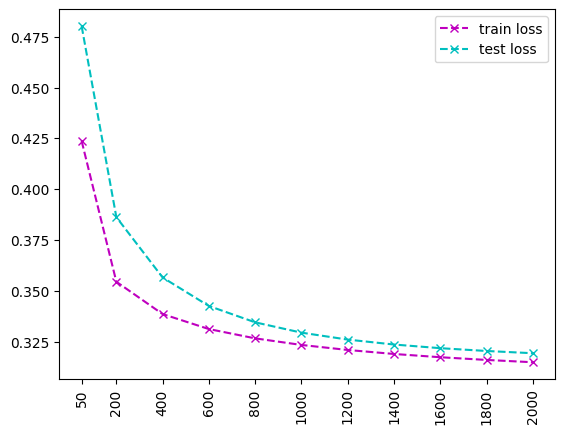

In [ ]:
hyperparameters = {
    "epochs": 2000,
    "learning_rate": 1e-3,
}

lr = LogisticRegression()
lr.setup(**hyperparameters)
lr.fit(iris_dataset)

train_loss, test_loss = lr.train_loss, lr.test_loss

plot_loss(train_loss, test_loss, first_tick=50, n_ticks=11)

## 4. K Nearest Neighbors

### General Idea

We assume that each observation in the $\mathbb{R}^d$ space (where $d$ is the number of features) is close to other observations which belong to the same class. We fit the model to the train data by storing the train observations, and then for each new observation find the most frequent class among the $\text{K}$ (hyperparameter) closest train observations.

### Math and Implementation

The model doesn't have any parameters, it merely stores the training data in its entirety and then finds the $\text{K}$ closest observations to the new observation $\b{x}$.

Therefore our model doesn't have any parameters other than
- `x_train`: the training observations
- `y_train`: the class of each training observation

In [ ]:
class KNearestNeighbors(BaseModel):
    def __init__(self):
        super().__init__("K Nearest Neighbors")
        self.x_train = None
        self.y_train = None

    def setup(self, n_neighbors):
        self.k = n_neighbors

We define the distance of an observation $\b{x}$ to another $\b{x}^{train}$ as the $L^2$ norm of their difference:

$$||\b{x}^{train} - \b{x}||_2 = \sqrt{\sum_j (\b{x}_j^{train} - \b{x}_j)^2}$$

In [ ]:
def KNearestNeighbors_distance(self, x):
    return np.sqrt(np.sum(
        np.power(self.x_train - x, 2),
        axis=1,
    ))

KNearestNeighbors._distance = KNearestNeighbors_distance

To fit the model to some data, we just need to store that data along with the given hyperparameter $\text{K}$.

In [ ]:
def KNearestNeighbors_fit_impl(self):
    self.x_train = self.dataset.x_train
    self.y_train = self.dataset.y_train

KNearestNeighbors.fit_impl = KNearestNeighbors_fit_impl

We assign a new observation $\b{x}$ to class $C_k$ if, among the $\text{K}$ train ovservations $\b{x}^{train}$ closest to $\b{x}$, class $C_k$ is the most frequent one.

In [ ]:
def KNearestNeighbors_predict_one(self, x):
    # find distance from x to each x_train
    x_distances = self._distance(x)

    # find classes of K closest x_train
    indices_of_k_closest_x = np.argsort(x_distances)[:self.k]
    y_of_k_closest_x = self.y_train[indices_of_k_closest_x]

    # classify x as the most frequent class among K closest x_train
    unique_y, unique_y_counts = np.unique(y_of_k_closest_x, return_counts=True)
    y_hat = unique_y[np.argmax(unique_y_counts)]
    return y_hat

KNearestNeighbors.predict_one = KNearestNeighbors_predict_one

### Results and Comparison to sklearn

Specify a value for the hyperparameter $\text{K}$, in this case $\text{K} = [1, 2, ..., 10]$.

In [ ]:
k_nearest_neighbors_hyperparameters = {
    "n_neighbors": range(1, 10 + 1),
}

Call the `show_report()` function for the `KNearestNeighbors` model.

In [ ]:
show_report(
    KNearestNeighbors(),
    iris_dataset,
    k_nearest_neighbors_hyperparameters,
)

Model: K Nearest Neighbors
Fitting with hyperparameters: n_neighbors = 1
	Train accuracy: 1.0000
	Test accuracy: 0.9400
Fitting with hyperparameters: n_neighbors = 2
	Train accuracy: 0.9700
	Test accuracy: 0.9200
Fitting with hyperparameters: n_neighbors = 3
	Train accuracy: 0.9700
	Test accuracy: 0.9400
Fitting with hyperparameters: n_neighbors = 4
	Train accuracy: 0.9400
	Test accuracy: 0.9200
Fitting with hyperparameters: n_neighbors = 5
	Train accuracy: 0.9600
	Test accuracy: 0.9200
Fitting with hyperparameters: n_neighbors = 6
	Train accuracy: 0.9600
	Test accuracy: 0.9200
Fitting with hyperparameters: n_neighbors = 7
	Train accuracy: 0.9800
	Test accuracy: 0.9600
Fitting with hyperparameters: n_neighbors = 8
	Train accuracy: 0.9600
	Test accuracy: 0.9400
Fitting with hyperparameters: n_neighbors = 9
	Train accuracy: 0.9700
	Test accuracy: 0.9600
Fitting with hyperparameters: n_neighbors = 10
	Train accuracy: 0.9600
	Test accuracy: 0.9600


Import the [`KNeighborsClassifier`] model from sklearn and call the `show_report()` function for that model.

[`KNeighborsClassifier`]: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

show_report(
    SklearnModelAdapter(KNeighborsClassifier),
    iris_dataset,
    k_nearest_neighbors_hyperparameters,
)

Model: KNeighborsClassifier
Fitting with hyperparameters: n_neighbors = 1
	Train accuracy: 1.0000
	Test accuracy: 0.9400
Fitting with hyperparameters: n_neighbors = 2
	Train accuracy: 0.9700
	Test accuracy: 0.9200
Fitting with hyperparameters: n_neighbors = 3
	Train accuracy: 0.9700
	Test accuracy: 0.9400
Fitting with hyperparameters: n_neighbors = 4
	Train accuracy: 0.9400
	Test accuracy: 0.9200
Fitting with hyperparameters: n_neighbors = 5
	Train accuracy: 0.9600
	Test accuracy: 0.9200
Fitting with hyperparameters: n_neighbors = 6
	Train accuracy: 0.9600
	Test accuracy: 0.9200
Fitting with hyperparameters: n_neighbors = 7
	Train accuracy: 0.9800
	Test accuracy: 0.9600
Fitting with hyperparameters: n_neighbors = 8
	Train accuracy: 0.9600
	Test accuracy: 0.9400
Fitting with hyperparameters: n_neighbors = 9
	Train accuracy: 0.9700
	Test accuracy: 0.9600
Fitting with hyperparameters: n_neighbors = 10
	Train accuracy: 0.9600
	Test accuracy: 0.9600


## 5. Naive Bayes

Source: https://datascience.stackexchange.com/questions/47027/how-does-naive-bayes-classifier-work-for-continuous-variables/47031#47031

### General Idea

We assume that the data of each class follow a Gaussian distribution, each with different mean and standard deviation. We fit the data of each class to find the prior probability, mean and standard deviation of each class. Then, for each new observation we take the argmax of the posterior probabilities of each it being generated from each class.

### Math and Implementation

$\newcommand{\ph}{\hat{\pi}}$
$\newcommand{\mh}{\hat{\mu}}$
$\newcommand{\sh}{\hat{\sigma}}$
The likelihood of each feature $x_i$ of $\b{x}$ given $C_k$ is assumed to be:

$$\hat{P}(x_i|C_k) = \frac{1}{\sqrt{2\pi\sh_{i, k}^2}}\exp\left(-\frac{(x_i-\mh_{i,k})^2}{2\sh_{i,k}^2}\right)$$

where $\mh_k$ and $\sh_k$ the vectors with the estimates for the mean and standard deviation of the gaussian for each feature of each class.

We will also need the prior probability of each class, $\ph_k$.

Multiplying the prior probability and the likelihood will give us the posterior for each class, which will be what we will use to classify new observations.

Therefore our model has 3 kinds of parameters:
- `p`: the prior probability of each class
- `m`: the mean of each feature for each class
- `s`: the standard deviation of each feature for each class

In [ ]:
class NaiveBayes(BaseModel):
    def __init__(self):
        super().__init__("Naive Bayes")
        self.p = {} # prior
        self.m = {} # mean
        self.s = {} # std

We approximate the prior probability $\ph$ of each class as follows:

$$\ph_k = \frac{N_k}{N}$$

and the mean and standard deviation vectors $\mh_k$ and $\sh_k$ of each class as follows:

$$\mh_{k}=\frac{\sum_{n:n\in C_k}x_{n}}{N_k}, \sh_{k}^2=\frac{\sum_{n:n\in C_k}(x_{n}-\mh_{k})^2}{N_k-1}$$

Therefore, to fit the model to some data, we just need to estimate the above parameters for each class according to that training data.

In [ ]:
def NaiveBayes_fit_impl(self):
    # calculate the model's parameters for each class
    for k in self.dataset.classes:
        # get indices of observations for klass k
        indices_k = np.flatnonzero(self.dataset.y_train == k)
        n_k = indices_k.shape[0]
        x_train_k = self.dataset.x_train[indices_k]

        self.p[k] = n_k / self.dataset.n_train
        self.m[k] = np.sum(x_train_k, axis=0) / n_k
        self.s[k] = np.sum((x_train_k - self.m[k]) ** 2, axis=0) / (n_k - 1)

NaiveBayes.fit_impl = NaiveBayes_fit_impl

We assign a new observation $\b{x}$ to the class $C_k$ if the posterior probability for this class is the maximum:

$$k = {argmax}_j(\ph\cdot\prod_i\hat{P}(x_i=x_{i}|C_k))$$

In [ ]:
def NaiveBayes_predict_one(self, x):
    # probability for each class c
    y_hat_k = {}

    # calculate posterior for each class
    for k in self.dataset.classes:
        y_hat_k[k] = (self.p[k] * np.prod(
            1 / (np.sqrt(2 * np.pi * self.s[k]))
            * np.exp(-(x - self.m[k]) ** 2 / (2 * self.s[k]))
        ))

    # take argmax ()
    return max(y_hat_k.keys(), key=y_hat_k.get)

NaiveBayes.predict_one = NaiveBayes_predict_one

### Results and Comparison to sklearn

Call the `show_report()` function for the `NaiveBayes` model.

In [ ]:
show_report(
    NaiveBayes(),
    iris_dataset,
)

Model: Naive Bayes
Train accuracy: 0.9600
Test accuracy: 0.9600


We import the [`GaussianNB`] model from sklearn and call the `show_report()` function for that model.

[`GaussianNB`]: https://scikit-learn.org/stable/modules/naive_bayes.html

In [ ]:
from sklearn.naive_bayes import GaussianNB

show_report(
    SklearnModelAdapter(GaussianNB),
    iris_dataset,
)

Model: GaussianNB
Train accuracy: 0.9600
Test accuracy: 0.9600


## 6. Multilayer Perceptron

### General Idea

We assume that our data can be classified using an adequately complex function which maps the four features of each observation to a class. We create an MLP to calculate that function and use it to classify our data.

### Implementation

We construct an MLP with a hidden layer which has `num_hidden` neurons. Addittionaly, our model will have a `loss function` and an `optimizer`, which will be used during training. The train and test loss at each epoch will also be calculated and stored to graph the model's performance across epochs.

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.relu1 = nn.ReLU() # activation function
        self.fc2 = nn.Linear(num_hidden, num_outputs)

        # loss function and optimizer
        self.criterion = None
        self.optimizer = None

        # store the loss values of every epoch during training
        self.train_loss_ls = None
        self.test_loss_ls = None

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

The MLP has $4$ input neurons (one for each feature), $64$ neurons in the hidden layer, and $3$ output neurons (one for each class).

It is parameterized by the following:
- `loss function` (criterion): Cross Entropy Loss
- `optimizer`: Stochastic Gradient Descent

In [ ]:
# Instantiate the model
model = MLP(num_inputs=4, num_hidden=64, num_outputs=3)

# Define the loss function
model.criterion = nn.CrossEntropyLoss()

# Define the optimizer (Stochastic Gradient Descent)
model.optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

To train the model with a specific dataset we clear its stored loss values and then, for a given number of epochs, pass the train data set (in batches), calculate and store the loss, and update the gradients using the model's optimizer.

In [ ]:
def train_model(model, dataset, num_epochs):
    # Training the model
    train_batch_size = int(dataset.n_train)
    test_batch_size = int(dataset.n_test)

    model.train_loss_ls = np.zeros(num_epochs)
    model.test_loss_ls = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        for ((x_train, y_train), (x_test, y_test)) in zip(
            dataset.get_train_dataloader(train_batch_size),
            dataset.get_test_dataloader(test_batch_size)):

            # Forward pass
            outputs_train = model(x_train).squeeze(dim=1)
            outputs_test = model(x_test).squeeze(dim=1)
            loss_train = model.criterion(outputs_train, y_train)
            loss_test = model.criterion(outputs_test, y_test)

            # Backward pass and optimization
            model.optimizer.zero_grad()
            loss_train.backward()
            model.optimizer.step()

            # Save loss at each epoch to create graph
            model.train_loss_ls[epoch] = loss_train.item()
            model.test_loss_ls[epoch] = loss_test.item()

train_model(model, iris_dataset, 15000)

### Results

We use the model to predict the probabilities of each class for both our train and test data, which are then converted to a single class by applying the `argmax()` function to them.

We pass the ground truth and the model's prediction to the `classification_report()` function of sklearn to produce the results.

In [ ]:
def evaluate_model(model, dataset):
    model.eval()

    with torch.no_grad():
        y_hat_train_prob = model(torch.Tensor(dataset.x_train))
        y_hat_test_prob = model(torch.Tensor(dataset.x_test))

    y_hat_train = np.array(np.argmax(y_hat_train_prob, axis=1))
    y_hat_test = np.array(np.argmax(y_hat_test_prob, axis=1))

    print(classification_report(dataset.y_train, y_hat_train))
    print(classification_report(dataset.y_test, y_hat_test))

evaluate_model(model, iris_dataset)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      0.97      0.98        32
           2       0.97      1.00      0.98        31

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.95      1.00      0.97        18
           2       1.00      0.95      0.97        19

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



We also call the `plot_loss()` function with the model's loss values.

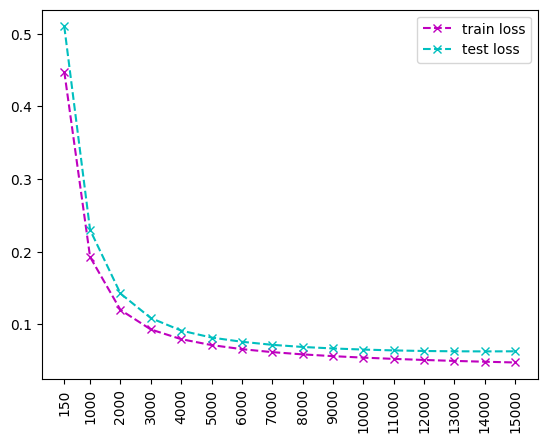

In [ ]:
plot_loss(model.train_loss_ls, model.test_loss_ls, first_tick=150, n_ticks=16)

## 7. K-Means


Source: https://en.wikipedia.org/wiki/K-means_clustering

### General idea

We want to separate our data points into $3$ clusters, based on their $4$ features. The number of the clusters was not chosen arbitrarily, we set it equal to the number of classes in our dataset.

We choose 3 random data points and assign them the centroid role. Then, we calculate the Eucledian distance of each data point from these centroids, pick the smallest distance for each data point, and re-compute the centroids. The algorithm stops when it converges, when the centroids remain the same after an iteration of this algorithm.

### Math and Implementation

Given a set of observations $(\b{x_1}, \b{x_2}, ..., \b{x_n})$, where each observation is a $d$-dimensional real vector, k-means clustering aims to partition the $n$ observations into $k (\leq n)$ sets $\b{S} = \{S_1, S_2, ..., S_k\}$ so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance). Formally, the objective is to find:

We assign a new observation $\b{x}$ to the class $C_k$ if the posterior probability for this class is the maximum:

$$\text{argmin}_{\b{S}}\sum_{i=1}^{k}\sum_{x\in S_i}\|\b{x} - \boldsymbol{\mu}_i\|^2 = \text{argmin}_{\b{S}}\sum_{i=1}^{k}|S_i|\text{Var}S_i$$

where $\boldsymbol{\mu}_i$ is the mean (also called centroid) of points in $S_i$, i.e.

$$\boldsymbol{\mu}_i = \frac{1}{|S_i|}\sum_{x\in S_i}x$$

where $|S_i|$ is the size of $S_i$, and $\|\cdot\|$ is the usual $L_2$ norm. This is equivalent to minimizing the pairwise squared deviations of points in the same cluster:

$$\text{argmin}_{\b{S}}\sum_{i=1}^{k}\frac{1}{|S_i|}\sum_{\b{x}, \b{y} \in S_i}\|\b{x} - \b{y}\|^2$$

The equivalence can be deduced from identity:

$$|S_i|\sum_{\b{x} \in S_i}\|\b{x} - \boldsymbol{\mu}_i\|^2 = \frac{1}{2}\sum_{\b{x}, \b{y}\in S_i}\|\b{x} - \b{y}||^2 $$

Since the total variance is constant, this is equivalent to maximizing the sum of squared deviations between points in different clusters (between-cluster sum of squares, BCSS). This deterministic relationship is also related to the law of total variance in probability theory.

Given an initial set of $k$ centroids $m_i^{(1)}, ..., m_k^{(1)}$, the algorithm proceeds by alternating between two steps:

1. Assignment step: Assign each observation to the cluster with the nearest mean: that with the least squared Euclidean distance.

$$S_i^{(t)} = \left\{x_p : \|x_p - m_i^{(t)}\|^2 \leq \|x_p - m_j^{(t)}\|^2 \ \ \ \forall j , 1 \leq j \leq k \right\} $$

where each $x_p$ is assigned to exactly one $S^{(t)}$, even if it could be assigned to two or more of them.

In [ ]:
def assign_clusters(data, centroids):
    distances = np.linalg.norm(data - centroids[:, np.newaxis], axis=2)
    return np.argmin(distances, axis=0)

2. Update step: Recalculate centroids for observations assigned to each cluster.

$$m_i^{(t+1)} = \frac{1}{|S_i^{(t)}|}\sum_{x_j\in S_i^{(t)}}x_j $$

In [ ]:
def update_centroids(data, clusters):
    return np.array([data[clusters == i].mean(axis=0) for i in range(num_clusters)])

Now we run the K-Means algorithm. The algorithm has converged when the centroids no longer change.

In [ ]:
# set the number of clusters equal to the number of different classes in the dataset
num_clusters = iris_dataset.n_classes
max_iterations = 100

# initialize centroids
idx = np.random.randint(low=0, high=iris_dataset.n_examples, size=(num_clusters,))
centroids = iris_dataset.x[idx]

for i in range(max_iterations):
    clusters = assign_clusters(iris_dataset.x, centroids)
    new_centroids = update_centroids(iris_dataset.x, clusters)

    # check for convergence
    if np.all(centroids == new_centroids):
        break

    centroids = new_centroids

### Results and Comparison to sklearn

Before plotting the results, we need to match the clusters of kmeans to the labels of our dataset. This will result in matching colors in the scatterplot and a readable confusion matrix.

In [ ]:
# https://stackoverflow.com/questions/45114760/how-to-plot-the-confusion-similarity-matrix-of-a-k-mean-algorithm/45133875#45133875
def match_clusters(y, y_hat):
    y_hat_matched = np.empty_like(y_hat)

    # For each cluster label...
    for k in np.unique(y_hat):
        # ...find and assign the best-matching y label
        match_nums = [np.sum((y_hat==k)*(y==t)) for t in np.unique(y)]
        y_hat_matched[y_hat==k] = np.unique(y)[np.argmax(match_nums)]

    return y_hat_matched

clusters_matched = match_clusters(iris_dataset.y, clusters)

Call the `plot_kmeans_clusters()` function with the results of the KMeans algorithm.

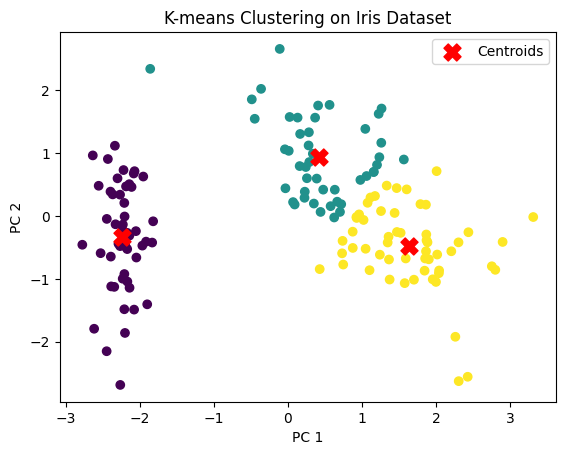

In [ ]:
plot_kmeans_clusters(PCA(), iris_dataset, clusters_matched, centroids)

Call the `plot_kmeans_confusion_matrix()` function with the results of the KMeans algorithm.

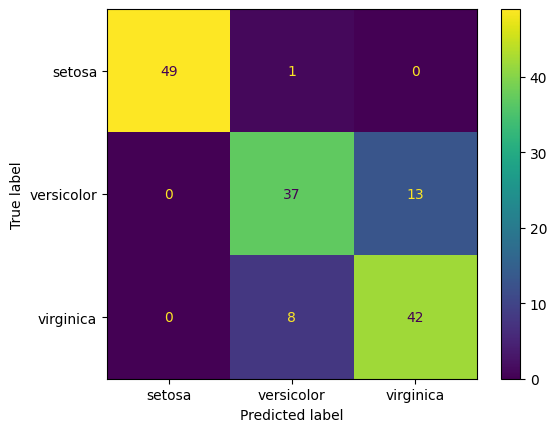

In [ ]:
plot_kmeans_confusion_matrix(iris_dataset.y, clusters_matched,
                             iris_dataset.y_labels)

We import the [`KMeans`] model from sklearn, perform clustering with it and also cluster matching, as described above.

[`KMeans`]:https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
sklearn_clusters = kmeans.fit_predict(iris_dataset.x)
sklearn_centroids = kmeans.cluster_centers_

sklearn_clusters_matched = match_clusters(iris_dataset.y, sklearn_clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Call the `plot_kmeans_clusters()` function with the results of the sklearn KMeans algorithm.

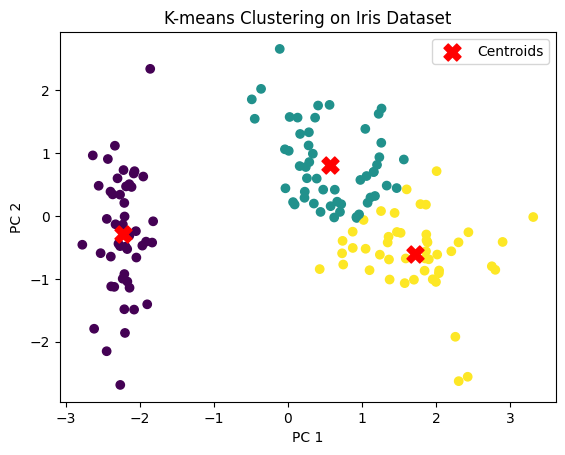

In [ ]:
plot_kmeans_clusters(PCA(), iris_dataset, sklearn_clusters_matched,
                     sklearn_centroids)

Call the `plot_kmeans_confusion_matrix()` function with the results of the sklearn KMeans algorithm.

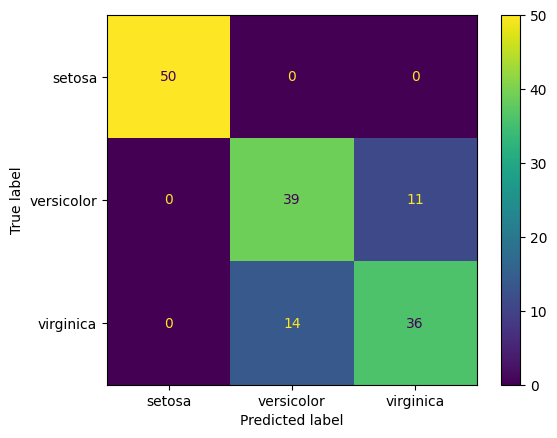

In [ ]:
plot_kmeans_confusion_matrix(iris_dataset.y, sklearn_clusters_matched,
                             iris_dataset.y_labels)